In [2]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [3]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [4]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [5]:
website_df["category"].count()

4309

In [13]:
classification_col = website_df["category"]
classification_col = pd.Series([(str(int(x))[:2] if not pd.isnull(x) else "00") for x in classification_col])

In [20]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from rapidfuzz import fuzz, process

session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        pattern = re.escape(phrase)
        phrase_count[phrase] = subset.apply(lambda x: len(re.findall(pattern, x, re.IGNORECASE)))

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        if not subset.loc[website]:
            continue
        phrase_count_sum = website_stats.sum()
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (((website_stats[phrase] / phrase_count_sum) if phrase_count_sum else 0) - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)
        websites_count += 1

    all_website_scores.append(website_scores)

    print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:01<00:00, 3798.65it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2304  Number of elements in website_scores:  2304
Category 43 had no websites in year 2007
Category 84 had no websites in year 2007
Category 86 had no websites in year 2007
Category 2 had no websites in year 2007
Category 47 had no websites in year 2007
Category 8 had no websites in year 2007
Year 2007 score: 0.5505948419879504


100%|██████████| 5189/5189 [00:01<00:00, 3665.86it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2436  Number of elements in website_scores:  2436
Category 43 had no websites in year 2008
Category 84 had no websites in year 2008
Category 86 had no websites in year 2008
Category 2 had no websites in year 2008
Category 8 had no websites in year 2008
Year 2008 score: 0.5496403678716248


100%|██████████| 5189/5189 [00:01<00:00, 3553.96it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2565  Number of elements in website_scores:  2565
Category 43 had no websites in year 2009
Category 84 had no websites in year 2009
Category 86 had no websites in year 2009
Category 2 had no websites in year 2009
Category 8 had no websites in year 2009
Year 2009 score: 0.5110961501309197


100%|██████████| 5189/5189 [00:01<00:00, 3529.04it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2717  Number of elements in website_scores:  2717
Category 43 had no websites in year 2010
Category 84 had no websites in year 2010
Category 86 had no websites in year 2010
Category 2 had no websites in year 2010
Category 8 had no websites in year 2010
Year 2010 score: 0.5075467378795466


100%|██████████| 5189/5189 [00:01<00:00, 3492.20it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2964  Number of elements in website_scores:  2964
Category 43 had no websites in year 2011
Category 84 had no websites in year 2011
Category 2 had no websites in year 2011
Category 8 had no websites in year 2011
Year 2011 score: 0.3768039899760015


100%|██████████| 5189/5189 [00:01<00:00, 3381.86it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3096  Number of elements in website_scores:  3096
Category 43 had no websites in year 2012
Category 84 had no websites in year 2012
Category 2 had no websites in year 2012
Category 8 had no websites in year 2012
Year 2012 score: 0.37239509951320066


100%|██████████| 5189/5189 [00:01<00:00, 3380.81it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3318  Number of elements in website_scores:  3318
Category 43 had no websites in year 2013
Category 84 had no websites in year 2013
Category 2 had no websites in year 2013
Category 8 had no websites in year 2013
Year 2013 score: 0.3039793769801872


100%|██████████| 5189/5189 [00:01<00:00, 3274.14it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3528  Number of elements in website_scores:  3528
Category 43 had no websites in year 2014
Category 84 had no websites in year 2014
Category 2 had no websites in year 2014
Category 8 had no websites in year 2014
Year 2014 score: 0.3043915319208379


100%|██████████| 5189/5189 [00:01<00:00, 3174.62it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3686  Number of elements in website_scores:  3686
Category 84 had no websites in year 2015
Category 2 had no websites in year 2015
Year 2015 score: 0.3357108216559837


100%|██████████| 5189/5189 [00:01<00:00, 3214.50it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3820  Number of elements in website_scores:  3820
Category 84 had no websites in year 2016
Category 2 had no websites in year 2016
Year 2016 score: 0.3352558860988891


100%|██████████| 5189/5189 [00:01<00:00, 3220.40it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3942  Number of elements in website_scores:  3942
Category 84 had no websites in year 2017
Category 2 had no websites in year 2017
Year 2017 score: 0.4981859219545274


100%|██████████| 5189/5189 [00:01<00:00, 3126.50it/s]


Websites count:  4090  Number of elements in website_scores:  4090
Year 2018 score: 0.5010550004941478


100%|██████████| 5189/5189 [00:01<00:00, 2918.00it/s]


Websites count:  4163  Number of elements in website_scores:  4163
Year 2019 score: 0.45841740587998053


100%|██████████| 5189/5189 [00:01<00:00, 2907.39it/s]

Websites count:  4341  Number of elements in website_scores:  4341
Year 2020 score: 0.46037892776935385


In [25]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.5505948419879803, 0.5496403678716555, 0.5110961501309018, 0.5075467378795254, 0.37680398997600184, 0.3723950995131979, 0.3039793769801736, 0.3043915319208231, 0.33571082165598015, 0.3352558860988883, 0.4981859219545489, 0.5010550004941694, 0.4584174058800082, 0.4603789277693837]
[0.13191339731592336, 0.13642303768959088, 0.18168062920572173, 0.19066245970870535, 0.10908132281952851, 0.11162091584371303, 0.11740524073247807, 0.11900976707195177, 0.0940022199924051, 0.09785538566781198, 0.17200474141992553, 0.17978799303255769, 0.15536707529477894, 0.164185115554966]


In [22]:
print([np.sum(scores) for scores in all_website_scores])

[1268.5705159403064, 1338.9239361353527, 1310.9616250857632, 1379.0044868186706, 1116.8470262888695, 1152.9352280928606, 1008.603572820216, 1073.893324616664, 1237.4300886239428, 1280.6774848977532, 1963.848904344832, 2049.3149520211527, 1908.391660678474, 1998.5049254468947]


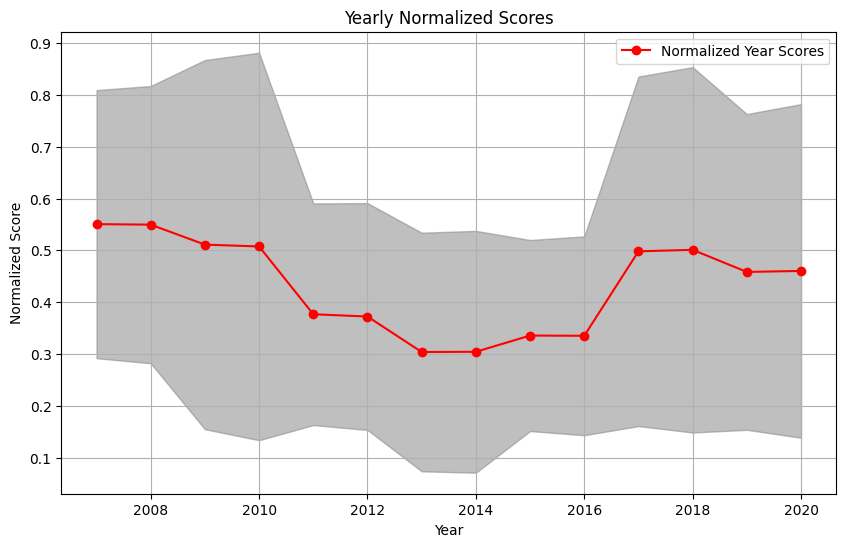

In [23]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]

plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Sum of Scores')

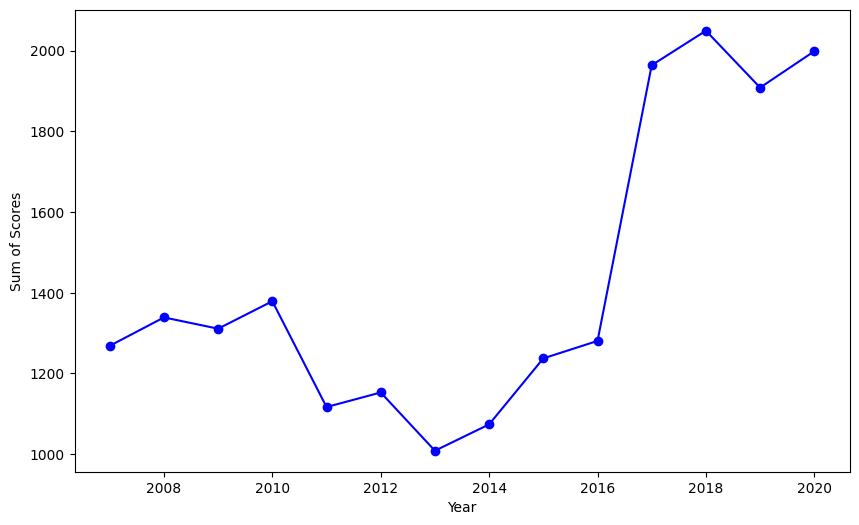

In [24]:
plt.figure(figsize=(10, 6))
value_sums = [np.sum(scores) for scores in all_website_scores]
plt.plot(years, value_sums, marker='o', color='b', label='Yearly Sums')
plt.xlabel('Year')
plt.ylabel('Sum of Scores')

In [ ]:
sic_classification = {
    "01-09": "Agriculture, Forestry, and Fishing",
    "10-19": "Mining and Extraction",
    "20-29": "Manufacturing (Food, Textiles, Chemicals, etc.)",
    "30-39": "Manufacturing (Machinery, Electronics, Transportation, etc.)",
    "40-49": "Transportation, Utilities, and Communication",
    "50-59": "Wholesale and Retail Trade",
    "60-69": "Finance, Insurance, and Real Estate",
    "70-79": "Services (Hotels, Business, Health, etc.)",
    "80-89": "Services (Education, Entertainment, Social, etc.)",
    "90-99": "Public Administration and Miscellaneous"
}

def classify_sic(sic_code):
    """Classifies a SIC code into a broad industry category."""
    first_two_digits = int(str(sic_code)[:2])  # Extract first two digits
    for range_key, industry in sic_classification.items():
        lower, upper = map(int, range_key.split('-'))
        if lower <= first_two_digits <= upper:
            return industry
    return "Unknown Industry"

sic_classifications = website_df["category"].apply(classify_sic)
categorized_normalized_year_scores_new = {category: [] for category in sic_classifications.unique()}


{'56': [0.5410259759892428,
  0.5420945587012972,
  0.5177807192193663,
  0.51357773822397,
  0.3794467999699437,
  0.3631152890582208,
  0.3016484210730585,
  0.3004680522242289,
  0.335395639256563,
  0.33166318585525867,
  0.4873521643109646,
  0.49624820544543174,
  0.45044025414230193,
  0.475967788793158],
 '20': [0.5412443259724489,
  0.5434643359825343,
  0.5207990703123081,
  0.5184396433645126,
  0.372394492203442,
  0.370710059731543,
  0.30011179124945264,
  0.2965481930657636,
  0.34638108029131975,
  0.3467151137819835,
  0.49991092768908174,
  0.5064897834414819,
  0.4484797963092467,
  0.43793622829421536],
 '37': [0.5369901145875708,
  0.5396715338252858,
  0.5220803297657909,
  0.5185198209503294,
  0.37813828506327407,
  0.3709988306009975,
  0.29925962706293496,
  0.30021661017973356,
  0.347528422615868,
  0.34667149357714006,
  0.4935245497238406,
  0.48699423651920143,
  0.46126330553947387,
  0.45713578313466285],
 '50': [0.5569937782585097,
  0.5580062093631438

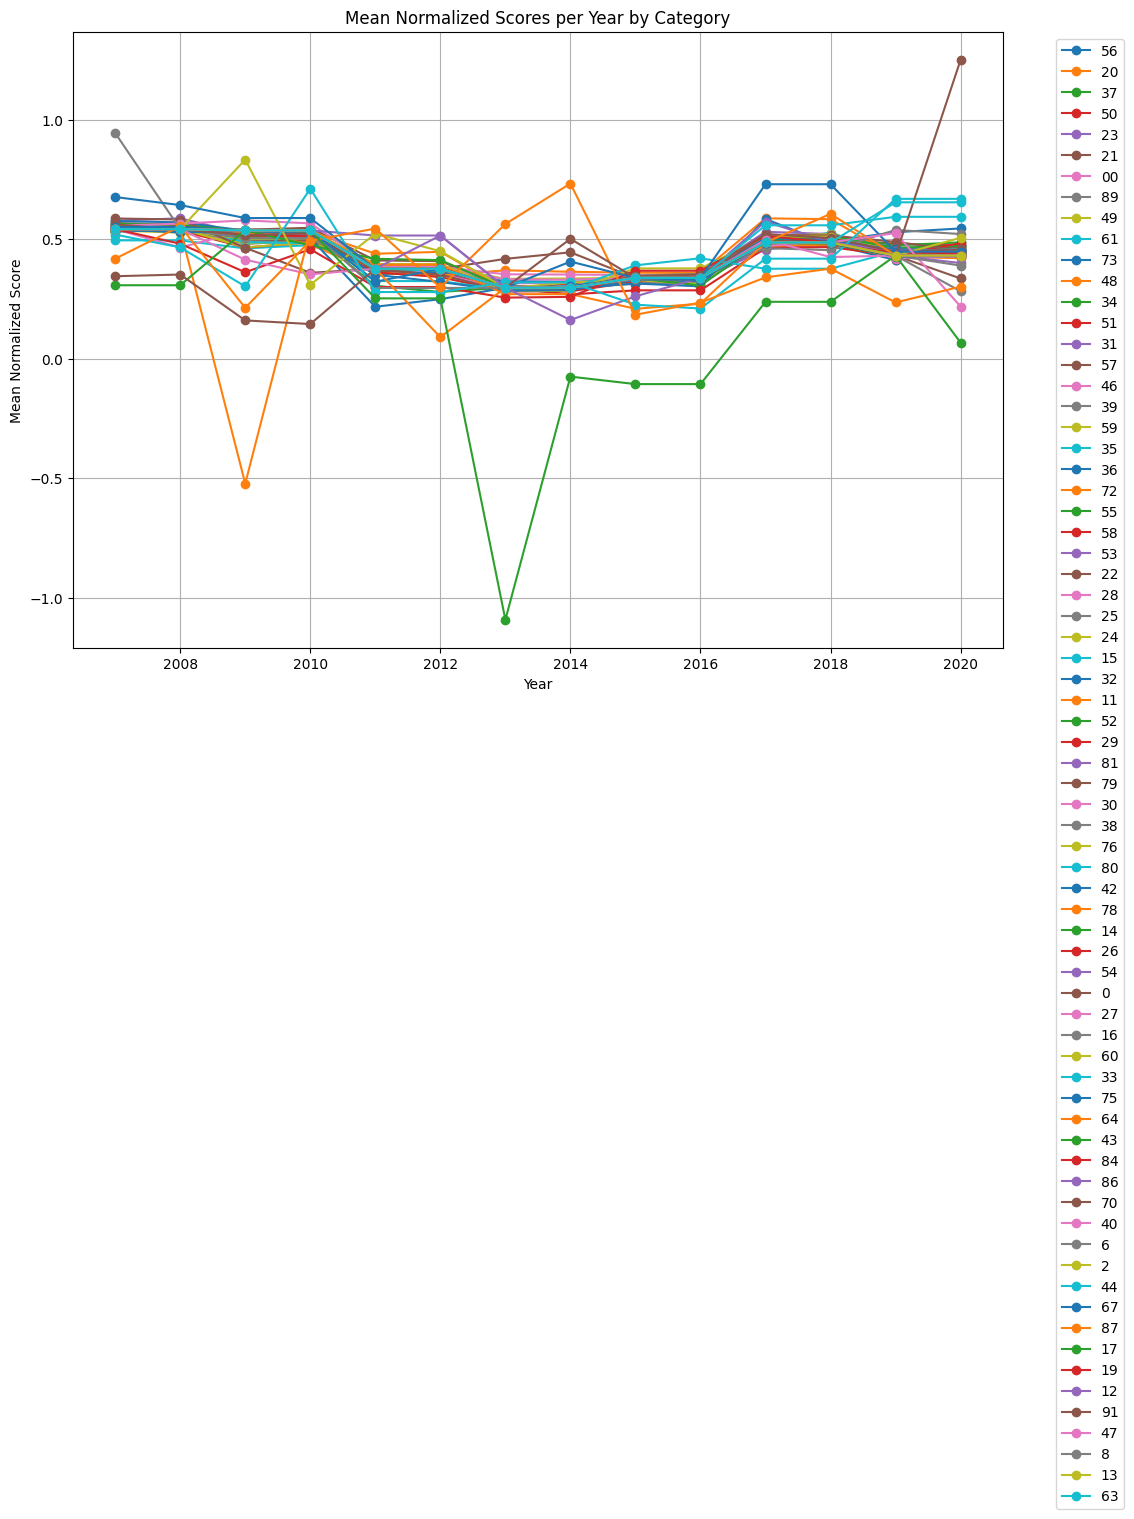

In [26]:
plt.figure(figsize=(12, 8))

for category, scores in categorized_normalized_year_scores.items():
    plt.plot(years, scores, marker='o', label=category)

plt.xlabel('Year')
plt.ylabel('Mean Normalized Score')
plt.title('Mean Normalized Scores per Year by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
classification_col.count()

5189

In [ ]:
# Create a DataFrame with the relevant data
data = {
    'Year': years,
    'Combined Normalized Year Scores': normalized_year_scores,
    'Combined Standard Deviation': year_std_devs,
    'Yearly Sums': value_sums
}

for category, scores in categorized_normalized_year_scores.items():
    data[f'{category} Mean Normalized Score'] = scores

df_graphed_data = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df_graphed_data.to_csv('graphed_data.csv', index=False)